# Импорт библиотек

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import random

from tqdm.notebook import tqdm

from math import floor
from math import ceil

from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.signal import peak_widths

from scipy.integrate import trapz
from scipy.integrate import simpson

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score

In [3]:
warnings.filterwarnings("ignore")

# Загрузка данных и их подготовка

In [4]:
path_ir = 'data/ftir'

In [5]:
path_to_curves = os.listdir(path_ir)
path_to_curves = sorted(path_to_curves, key=lambda x: int(x.split('.')[0]))
path_to_curves = [path_ir + '/' + filename for filename in path_to_curves]

ir_id = {}

for i, p in enumerate(path_to_curves):
    name = p.split('/')[-1].split('.')[0]
    ir_id[i] = name

In [6]:
def extract_ir_data(path):
    with open(path, 'r') as f:
        data = f.readlines()
        x_lst, y_lst = [], []
        for line in data:
            line = line.rstrip()
            x, y = map(float, line.split(','))
            x_lst.append(x)
            y_lst.append(y)
    return x_lst, y_lst

In [7]:
def find_width(y, height=0.1, prominence=0.01, rel_height=1):
    peaks, _ = find_peaks(y, height=height, prominence=prominence)
    result = peak_widths(y, peaks, rel_height=rel_height)
    width = result[1:]
    if len(width[0]) == 0:
        pass
    else:
        width = list(width)
        width[1] = [X[+floor(i)] for i in width[1]]
        width[2] = [X[+floor(i)] for i in width[2]]
        width = tuple(width)
    return width  # (y, x_min, x_max)


def integrate_peaks(x, y, height=0.1, prominence=0.01, rel_height=0.5):
    p, _ = find_peaks(y, height=height, prominence=prominence)
    peaks_positions = [x[j] for j in p]
    
    dict_peak_area = {}
    
    x1_lst, x2_lst = find_width(y, height=height, prominence=prominence, rel_height=rel_height)[1:]
    
    for peak_position, x1, x2 in zip(peaks_positions, x1_lst, x2_lst):
        i_start = x.index(x1)
        i_end = x.index(x2)
        y_integrate = y[i_start:i_end+1]
        x_integrate = x[i_start:i_end+1]
        y_rectangle = [y_integrate[0]] * len(y_integrate)
        full_area = abs(simpson(y_integrate, x_integrate))
        rectangle_area = abs(simpson(y_rectangle, x_integrate))
        area = full_area - rectangle_area
        dict_peak_area[peak_position] = area
    return dict_peak_area

In [8]:
full_X = extract_ir_data(path_to_curves[0])[0]

X = list(filter(lambda x: x >= 800, full_X))

In [10]:
Y = [extract_ir_data(p)[1][:len(X)] for p in path_to_curves]  # initial

Y_smooth_only = [savgol_filter(y, window_length=63, polyorder=3) for y in Y]  # smoothed

scaler = MinMaxScaler()
Y_smooth = list(scaler.fit_transform(np.array(Y_smooth_only).T).T)  # smoothed and normalized to [0...1]

In [11]:
P = []
X_m = []
Y_m = []

for i in range(len(Y_smooth)):
    p, _ = find_peaks(Y_smooth[i], height=0.1, prominence=0.01)
    x_m = [X[j] for j in p]
    y_m = [Y_smooth[i][j] for j in p]
    P.append(p)
    X_m.append(x_m)
    Y_m.append(y_m)

In [13]:
full_description = ['MFGO, разб. 1:20',
                    'HGO, 0.0116 г в 25 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'rGO, 2 г в 1000 мл H2O',
                    'rGO, RusGraphene, 2 г в 1000 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'GO, RusGraphene, 1.00 г в 250 мл H2O',
                    'rGO, RusGraphene, 0.20 г в 100 мл H2O',
                    'GO, RusGraphene, 1.00 г в 250 мл H2O',
                    'GO, USA, 0.1 г в 100 мл H2O',
                    'GO, RusGraphene, 2 г в 1000 мл H2O',
                    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
                    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в H2O',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М',
                    'Образец 10 после диализа 3.5 кДа, конд.',
                    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М (повторное использование)',
                    'Образец 9 после диализа 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М (повторное использование)',
                    'Образец 11 после диализа 2 дня, H2O, 1 кДа',
                    'Образец 11 после диализа 5 дней, H2O, 14 кДа 75 мм',
                    'Образец 9 после диализа при 25°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 9 после диализа при 45°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М',
                    'Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М']

short_description = ['$GO$',
                     '$GO$',
                     '$GO$',
                     '$rGO$',
                     '$rGO$',
                     '$GO$',
                     '$GO$',
                     '$rGO$',
                     '$GO$',
                     '$GO$',
                     '$GO$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$rGO$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$',
                     '$GO_{d}$']

class_lst = [0 if el == '$rGO$' else 1 if el == '$GO$' else 2 for el in short_description]

# Feature extraction

In [14]:
ir_id_lst = list(ir_id.values())
num_of_peaks = [len(y) for y in Y_m]

sum_int = [round(sum(y), 4) for y in Y_m]
all_area = [sum(integrate_peaks(X, y).values()) for y in Y_smooth]

cc_peak_int = [Y_m[i][1] for i in range(len(Y_m))]
cc_area = [list(integrate_peaks(X, y).values())[1] for y in Y_smooth]

co_peak_int = [Y_m[i][0] for i in range(len(Y_m))]
co_area = [list(integrate_peaks(X, y).values())[0] for y in Y_smooth]

In [22]:
data = {'$Type$': short_description,
        '$Class$': class_lst,
        '$n_{bands, n}$': num_of_peaks,
        '$(ΣI)_{n}$': sum_int,
        '$(ΣS)_{n}$': all_area,
        '$I_{1615, n}$': cc_peak_int,
        '$S_{1615, n}$': cc_area,
        '$I_{1720, n}$': co_peak_int,
        '$S_{1720, n}$': co_area
       }


In [23]:
df_ir = pd.DataFrame(data=data, index=ir_id.values())
df_ir.head(3)

$Type$  $Class$  $n_{bands, n}$  $(ΣI)_{n}$  $(ΣS)_{n}$  $I_{1615, n}$  \
1   $GO$        1               4      2.9151  120.871827       0.619070   
2   $GO$        1               6      3.9398   91.038460       0.670413   
3   $GO$        1               5      2.8628   85.811640       0.380586   

   $S_{1615, n}$  $I_{1720, n}$  $S_{1720, n}$  
1       3.720932       0.664008      30.809158  
2      12.073342       0.481810       0.972930  
3       8.608846       0.355102       4.681587

In [24]:
initial_ftir_features_df = df_ir.iloc[:, 3:]
initial_ftir_features_df.head(3)

$(ΣI)_{n}$  $(ΣS)_{n}$  $I_{1615, n}$  $S_{1615, n}$  $I_{1720, n}$  \
1      2.9151  120.871827       0.619070       3.720932       0.664008   
2      3.9398   91.038460       0.670413      12.073342       0.481810   
3      2.8628   85.811640       0.380586       8.608846       0.355102   

   $S_{1720, n}$  
1      30.809158  
2       0.972930  
3       4.681587

# Feature engineering

## Генерация фичей

In [87]:
initial_ftir_features = initial_ftir_features_df.columns
n_features = len(initial_ftir_features)

ftir_features_df = initial_ftir_features_df.copy()

for i in range(n_features):
    for j in range(i+1, n_features):
        feature1 = initial_ftir_features[i]
        feature1_clear = feature1.replace('_{n}', '').replace(', n', '').replace('$', '')
        
        feature2 = initial_ftir_features[j]
        feature2_clear = feature2.replace('_{n}', '').replace(', n', '').replace('$', '')
        
        new_feature = '$(\\frac{' + feature1_clear + '}{' + feature2_clear + '})_{n}$'
        column_values = initial_ftir_features_df[feature1] / initial_ftir_features_df[feature2]
        ftir_features_df[new_feature] = column_values
        
ftir_features = ftir_features_df.columns

scaler = MinMaxScaler()

ftir_features_df = pd.DataFrame(scaler.fit_transform(ftir_features_df),
                                columns=ftir_features,
                                index=ir_id.values())
ftir_features_df.head(3)

$(ΣI)_{n}$  $(ΣS)_{n}$  $I_{1615, n}$  $S_{1615, n}$  $I_{1720, n}$  \
1    0.470229    0.654616       0.503627       0.041810       1.000000   
2    0.892751    0.376269       0.570531       0.312728       0.662535   
3    0.448664    0.327503       0.192870       0.200354       0.427848   

   $S_{1720, n}$  $(\frac{(ΣI)}{(ΣS)})_{n}$  $(\frac{(ΣI)}{I_{1615}})_{n}$  \
1       1.000000                   0.182522                       0.358991   
2       0.028331                   0.627539                       0.532875   
3       0.149110                   0.397242                       0.777867   

   $(\frac{(ΣI)}{S_{1615}})_{n}$  $(\frac{(ΣI)}{I_{1720}})_{n}$  ...  \
1                       0.684518                       0.000000  ...   
2                       0.222841                       0.303321  ...   
3                       0.229123                       0.294096  ...   

   $(\frac{(ΣS)}{I_{1615}})_{n}$  $(\frac{(ΣS)}{S_{1615}})_{n}$  \
1                       0.583143                       0.910702   
2                       0.326213                       0.160813   
3                       0.713763                       0.233788   

   $(\frac{(ΣS)}{I_{1720}})_{n}$  $(\frac{(ΣS)}{S_{1720}})_{n}$  \
1                       0.135892                       0.000000   
2                       0.147822                       0.071503   
3                       0.238717                       0.011490   

   $(\frac{I_{1615}}{S_{1615}})_{n}$  $(\frac{I_{1615}}{I_{1720}})_{n}$  \
1                           0.819067                           0.024632   
2                           0.153009                           0.119753   
3                           0.084991                           0.053522   

   $(\frac{I_{1615}}{S_{1720}})_{n}$  $(\frac{S_{1615}}{I_{1720}})_{n}$  \
1                           0.000000                           0.016069   
2                           0.075339                           0.229625   
3                           0.006892                           0.220679   

   $(\frac{S_{1615}}{S_{1720}})_{n}$  $(\frac{I_{1720}}{S_{1720}})_{n}$  
1                           0.000000                           0.000000  
2                           0.135531                           0.260295  
3                           0.018949                           0.029839  

[3 rows x 21 columns]

In [26]:
path_to_save = 'results/ftir/step2'

## Корреляционная матрица на части фичей

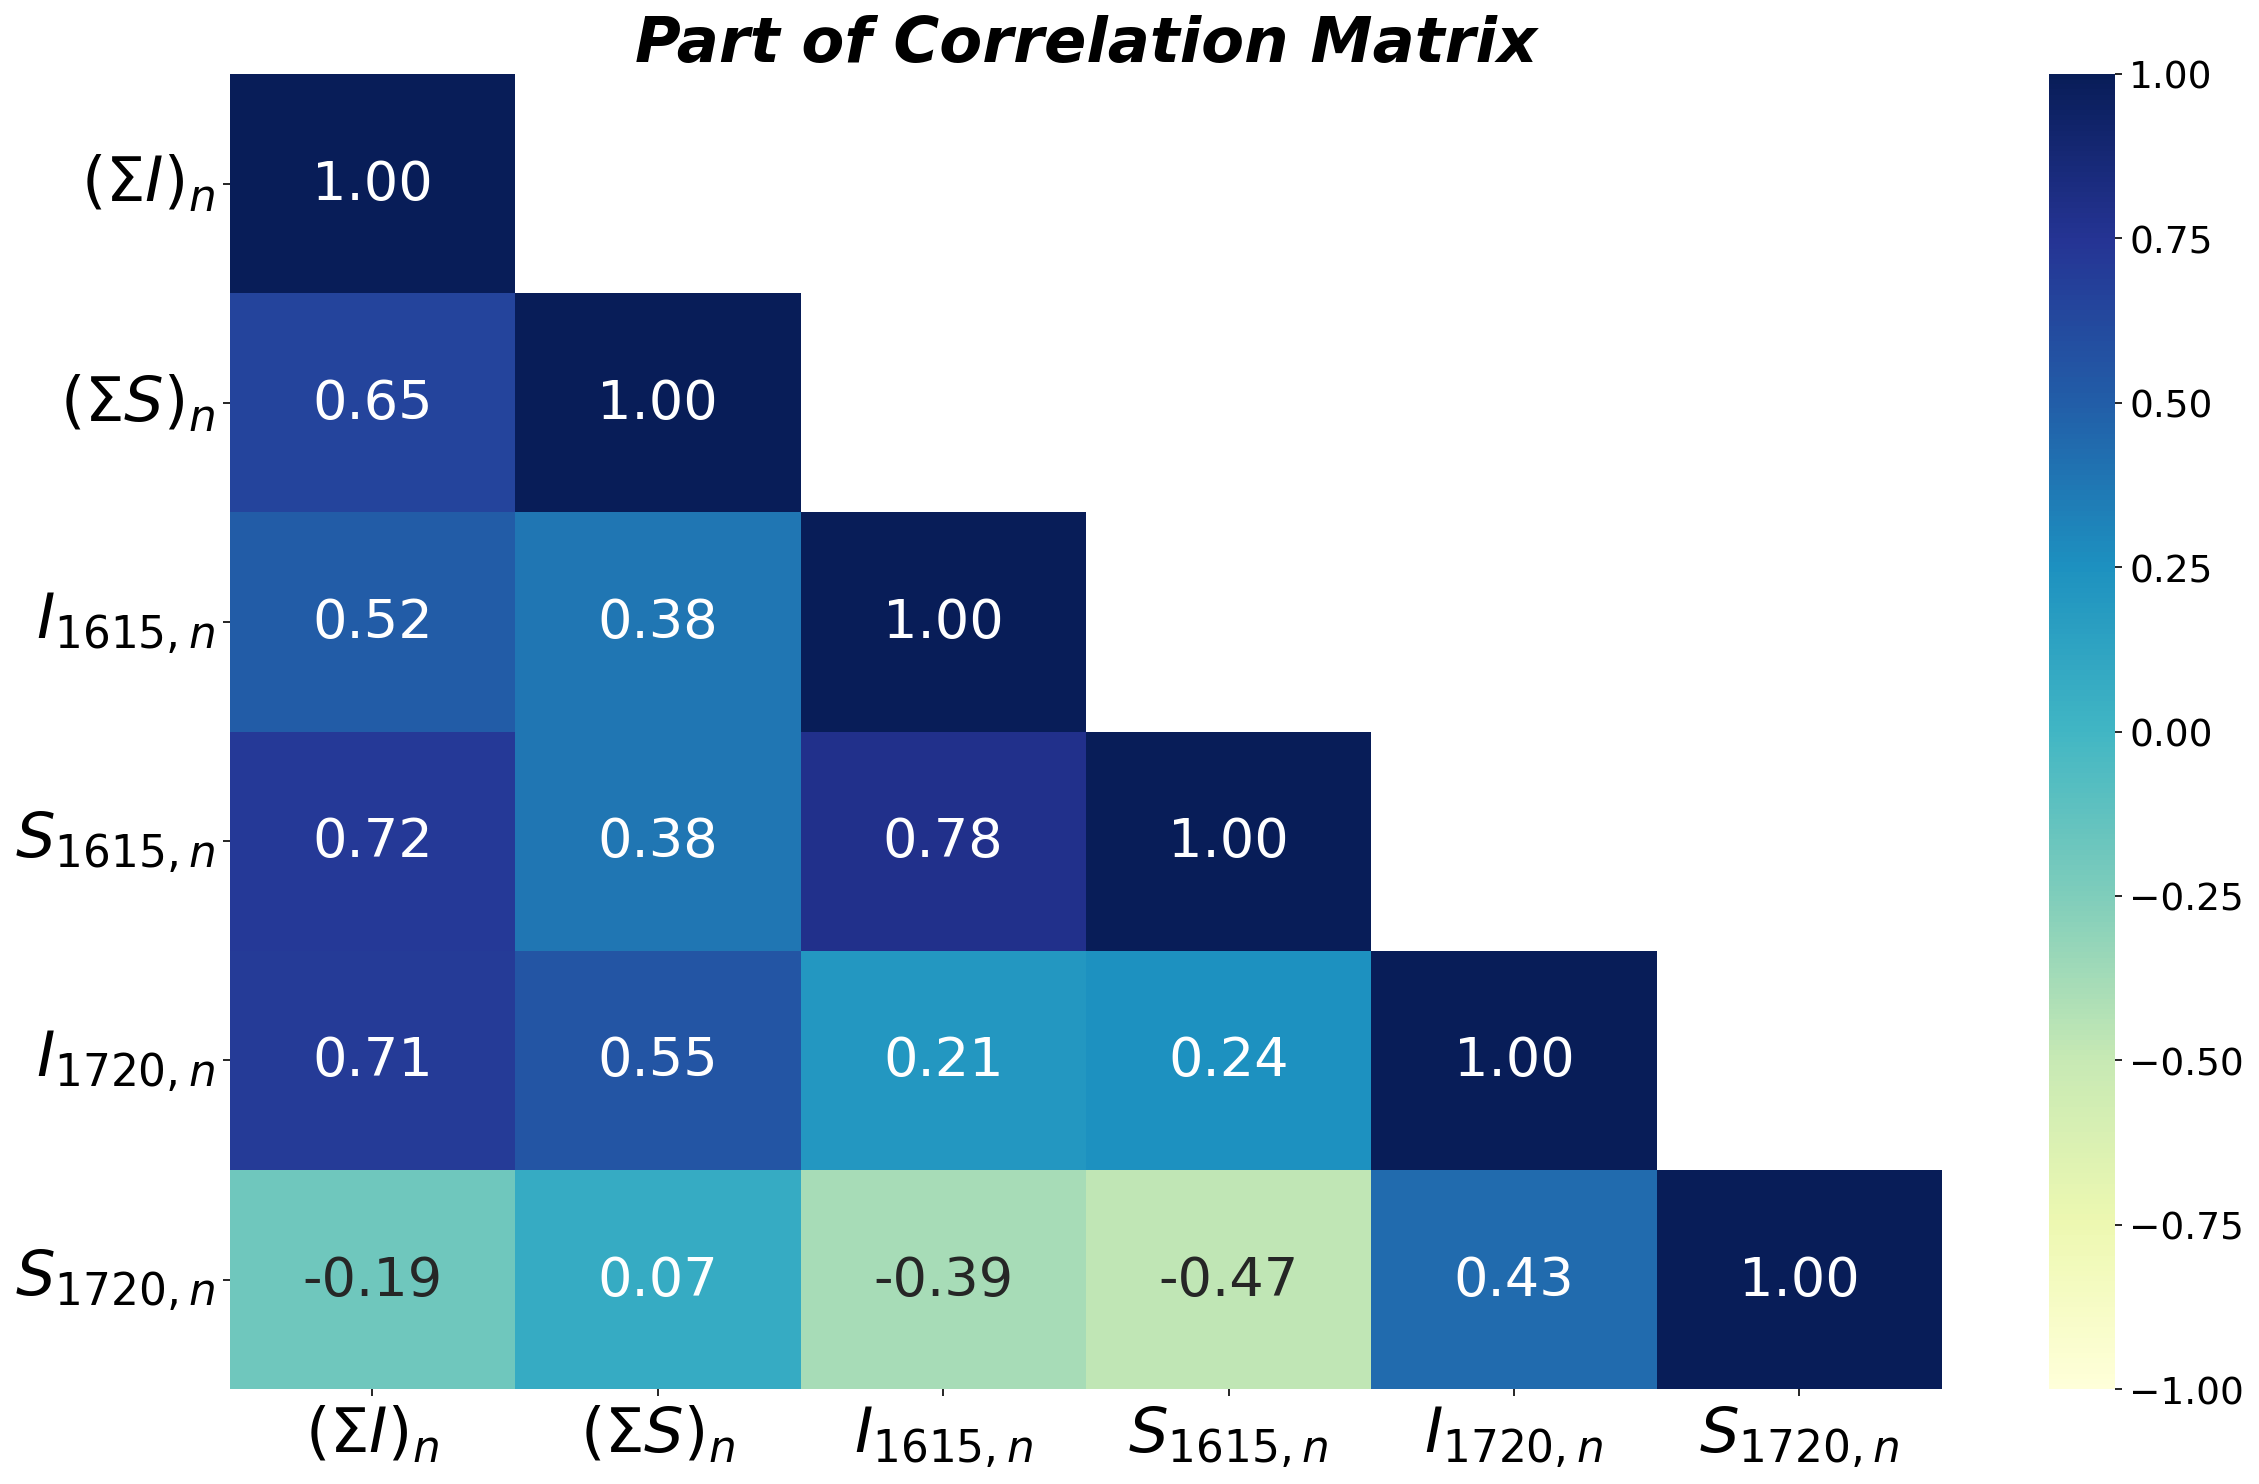

In [83]:
part_df_ir_corr = initial_ftir_features_df.copy()
columns_titles = part_df_ir_corr.columns

corr = part_df_ir_corr.corr()
corr = corr.where(np.tril(np.ones(corr.shape)).astype(bool))

fig = plt.figure(figsize=(16, 10), dpi=150)
ax = fig.gca()

title = 'Part of Correlation Matrix'
ax.set_title(f'{title}', fontweight='bold', fontstyle='italic', fontsize=30)

# cmap = [YlGnBu, PiYG, Reds, BuPu, rocket_r, icefire, flare, cubehelix, vlag, inferno]
# cmap = [gnuplot, ]

corr_plot = sns.heatmap(corr,
                        cmap='YlGnBu',
                        annot=True,
#                         mask=matrix,
                        vmax=1.0,
                        vmin=-1.0,
                        center=0.0,
                        fmt='.2f',
                        annot_kws={'size': 26},
                        ax=ax
                       )

corr_plot.figure.axes[-1].tick_params(labelsize=18)

corr_plot.set_yticklabels(corr_plot.get_yticklabels(), rotation=0, fontsize=30)
corr_plot.set_xticklabels(corr_plot.get_xticklabels(), rotation=0, fontsize=30)

plt.tight_layout()

plt.savefig(path_to_save + '/ftir_part_corr_matrix.png', dpi=600)

## Корреляционная матрица на всех фичах

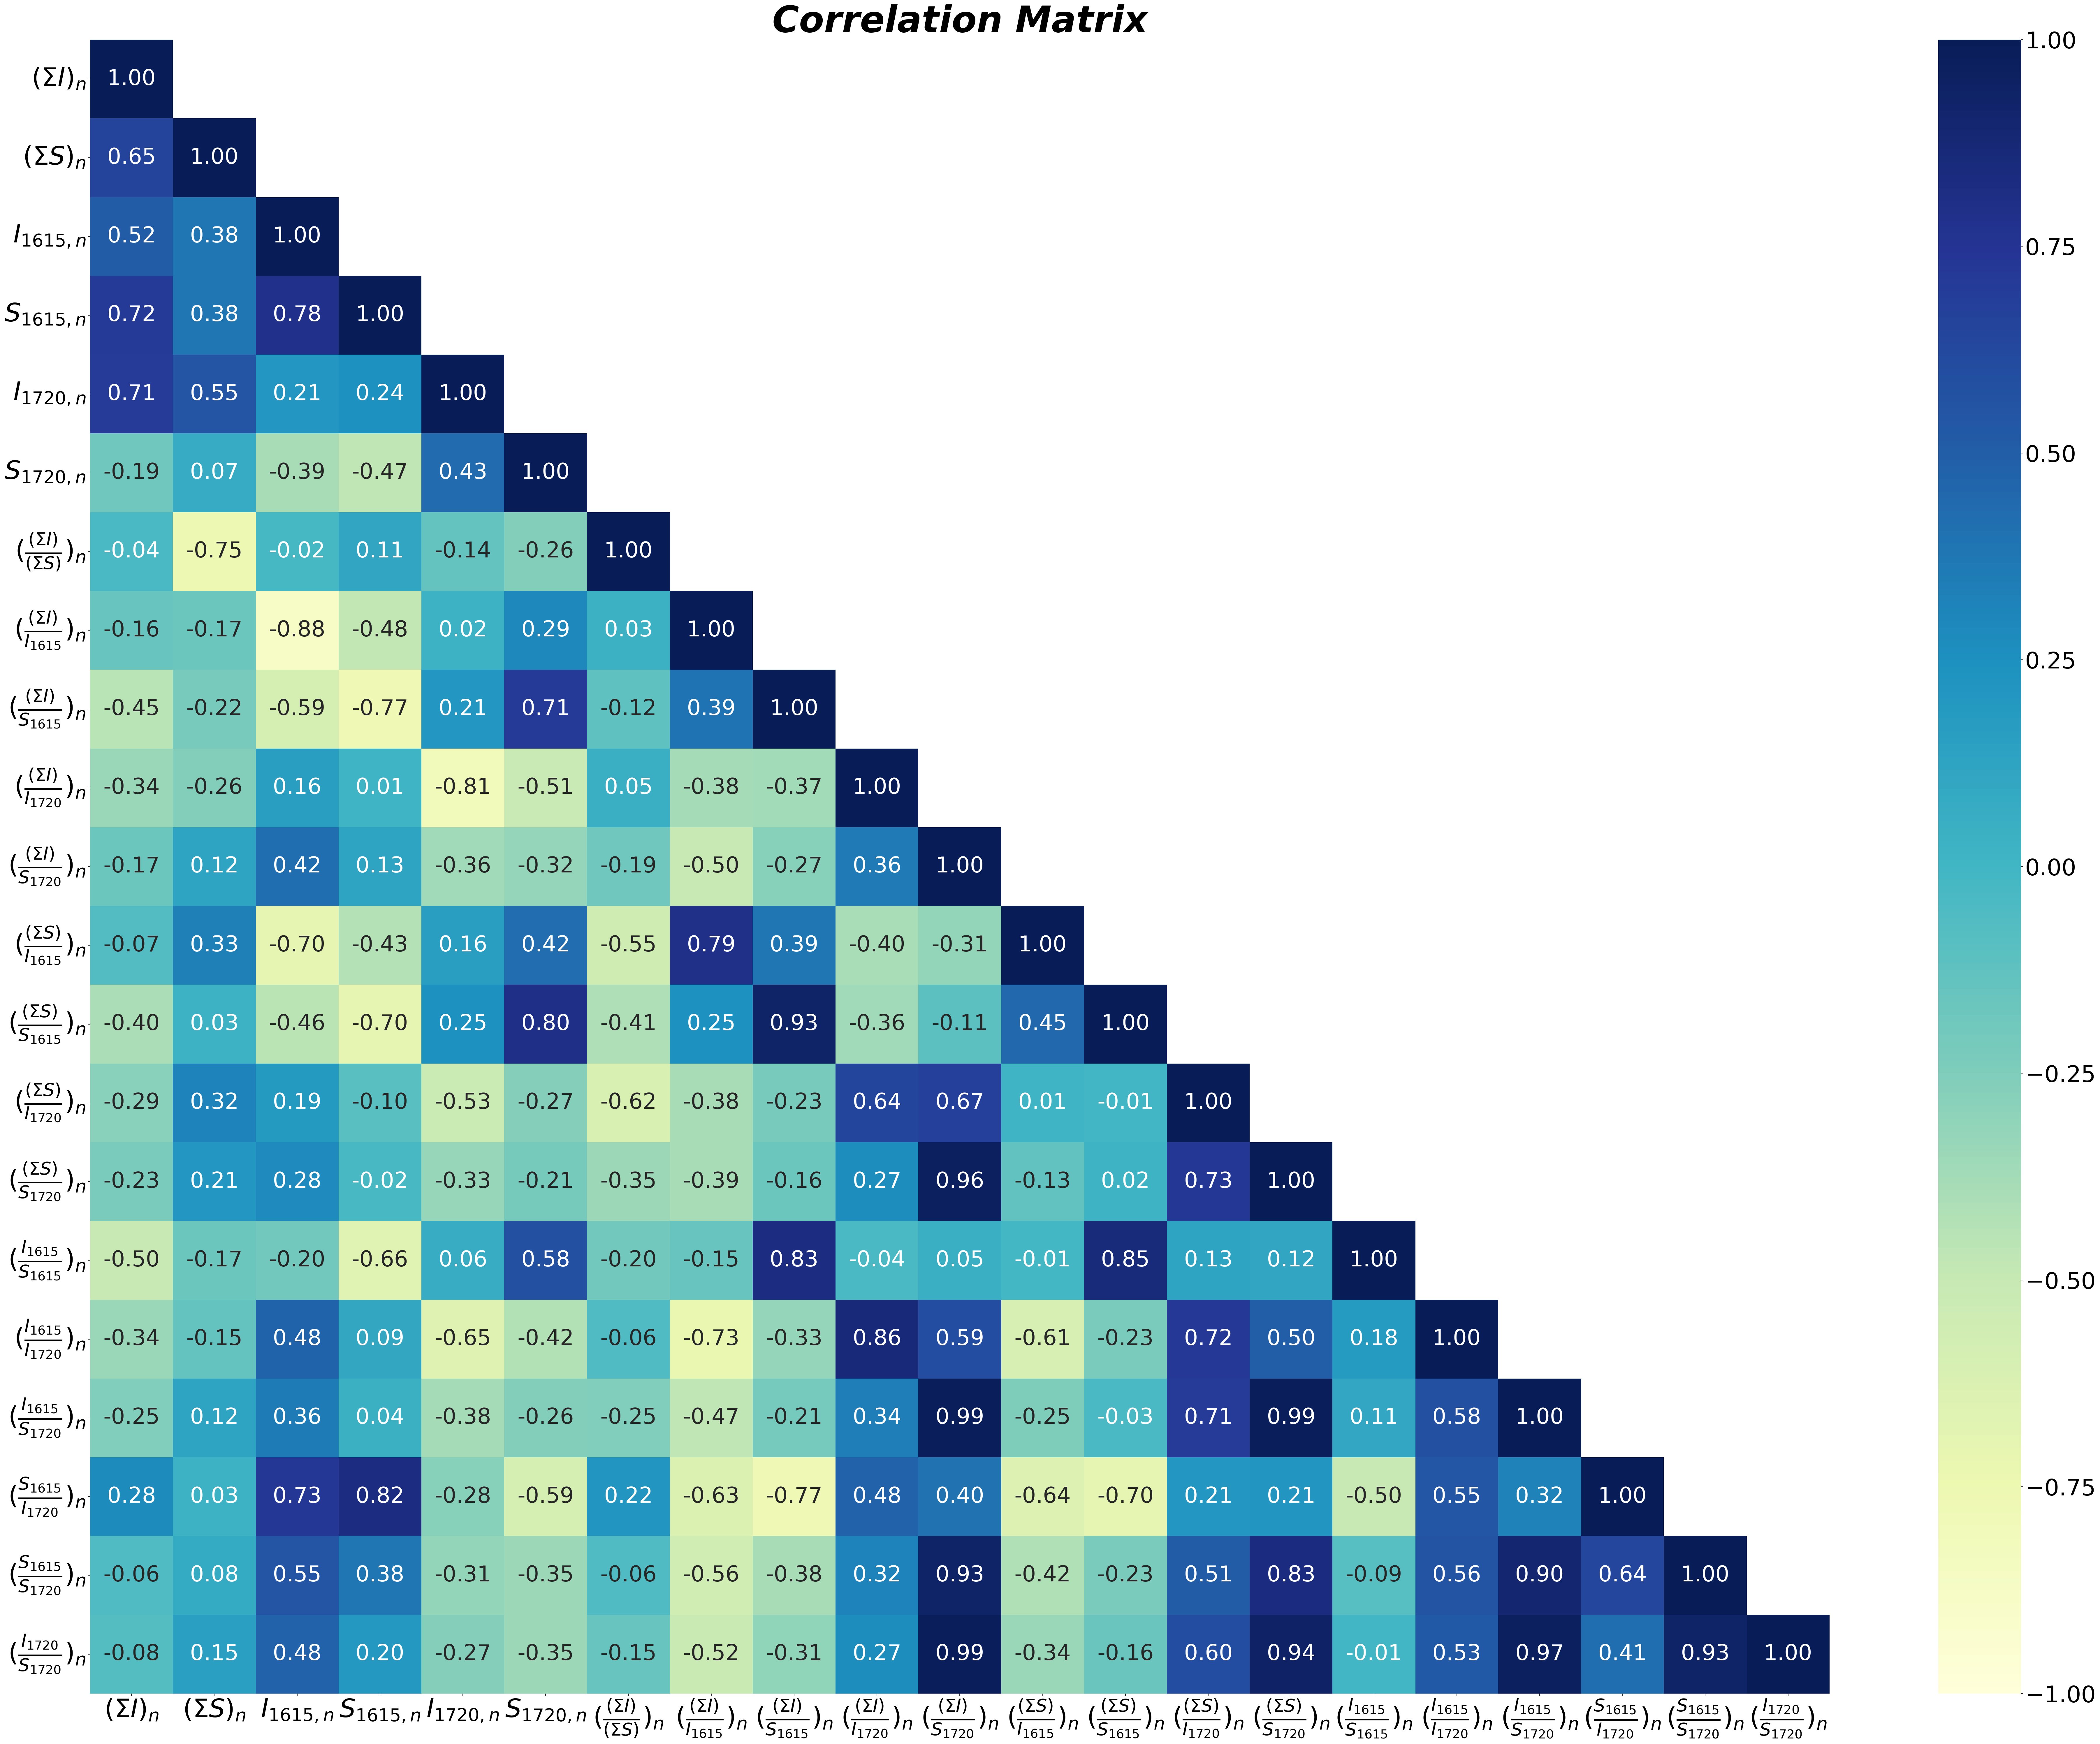

In [28]:
df_ir_corr = ftir_features_df.copy()
columns_titles = df_ir_corr.columns

corr = df_ir_corr.corr()
corr = corr.where(np.tril(np.ones(corr.shape)).astype(bool))

fig = plt.figure(figsize=(52, 40), dpi=150)
ax = fig.gca()

title = 'Correlation Matrix'
ax.set_title(f'{title}', fontweight='bold', fontstyle='italic', fontsize=60)

#  cmap = [YlGnBu, PiYG, Reds, BuPu, rocket_r, icefire, flare, cubehelix, vlag]
corr_plot = sns.heatmap(corr,
                        cmap="YlGnBu",
                        annot=True,
#                         mask=matrix,
                        vmax=1.0,
                        vmin=-1.0,
                        center=0.0,
                        fmt='.2f',
                        annot_kws={'size': 36},
                        ax=ax
                       )


corr_plot.set_yticklabels(corr_plot.get_yticklabels(), rotation=0, fontsize=42)
corr_plot.set_xticklabels(corr_plot.get_xticklabels(), rotation=0, fontsize=42)

plt.tight_layout()

plt.savefig(path_to_save + '/ftir_corr_matrix.png', dpi=600)

# Кластерный анализ

In [151]:
path_to_save = 'results/ftir/step2/cluster_analysis'

In [30]:
targets = list(df_ir['$Class$'])
description = list(df_ir['$Type$'])

## Основные функции

In [88]:
def calculate_v_measure(data,
                        targets,
                        max_n_clusters):
    v_measure = []
    for n_clusters in range(1, max_n_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=42)
        kmeans.fit(data)
        
        groups = kmeans.fit_predict(data)
        v_measure.append(v_measure_score(groups, targets))
        
    max_v_measure = round(max(v_measure), 3)
    return max_v_measure

In [136]:
def optimal_number_of_clusters(data,
                               metric='silhouette',
                               targets=[],
                               max_n_clusters=10):
    n_metric_value_dict = {}
    
    for n_clusters in range(2, max_n_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=42)
        kmeans.fit(data)
        
        if metric == 'silhouette':
            if n_clusters >= 2:
                n_metric_value_dict[n_clusters] = silhouette_score(data, kmeans.labels_)
        elif metric == 'v-measure':
            groups = kmeans.fit_predict(data)
            n_metric_value_dict[n_clusters] = v_measure_score(groups, targets)   
    
    opt_n_clusters = sorted(n_metric_value_dict.items(), key=lambda x:x[1], reverse=True)[0][0]
    return opt_n_clusters

In [132]:
def cluster_analysis(data,
                     n_clusters,
                     hue_col=[],
                     targets=[],
                     labels=[],
                     figsize=(16, 9),
                     markersize=600,
                     legend_size=20,
                     save='n',
                     name_of_file='curve',
                     dpi=300):
    if targets:
        figure_templ = [['upper left', 'right'],
                        ['middle left', 'right'],
                        ['lower left', 'right']]
    else:
        figure_templ = [['upper left', 'right'],
                        ['lower left', 'right']]
        
    fig, ax = plt.subplot_mosaic(figure_templ,
                                 gridspec_kw={'width_ratios': [3, 7], 'height_ratios': [1, 1, 1]},
                                 figsize=figsize,
                                 dpi=dpi,
                                 layout='constrained')
    
    clust_data = data.copy()

    x_range = list(range(1, 12))
    inertia = []
    silhouette = []
    if targets:
        v_measure = []
    for n_clusts in x_range:
        kmeans = KMeans(n_clusters=n_clusts, init='k-means++', random_state=42)
        kmeans.fit(clust_data)
        
        # inertia
        inertia.append(kmeans.inertia_)
        
        # v-measure
        groups = kmeans.fit_predict(clust_data)
        if targets:
            v_measure.append(v_measure_score(groups, targets))
        
        # silhouette-score
        if n_clusts >= 2:
            silhouette.append(silhouette_score(clust_data, kmeans.labels_))
    
    max_v_measure = round(max(v_measure), 3)
    mean_v_measure = round(np.mean(v_measure), 3)
    
    # Inertia Plot
    ax['upper left'].grid(False)
    ax['upper left'].tick_params(direction='in')
    ax['upper left'].set_title(f'Elbow method',
                               fontname='DejaVu Sans',
                               fontsize=20,
                               fontstyle='italic',
                               fontweight='heavy')
    ax['upper left'].plot(x_range,
                          inertia,
                          '-o',
                          color='orange')
    ax['upper left'].set_xlabel('$Number$ $of$ $clusters$',
                                fontname='DejaVu Sans',
                                fontsize=16)
    ax['upper left'].set_ylabel('$WCSS$',
                                fontname='DejaVu Sans',
                                fontsize=16)
    
    # V-measure Plot
    if targets:
        ax['middle left'].grid(False)
        ax['middle left'].tick_params(direction='in')
        ax['middle left'].set_title(f'V-measure',
                                   fontname='DejaVu Sans',
                                   fontsize=20,
                                   fontstyle='italic',
                                   fontweight='heavy')
        ax['middle left'].plot(x_range,
                              v_measure,
                              '-o',
                              color='orange')
        ax['middle left'].set_xlabel('$Number$ $of$ $clusters$',
                                    fontname='DejaVu Sans',
                                    fontsize=16)
        ax['middle left'].set_ylabel('$V$',
                                    fontname='DejaVu Sans',
                                    fontsize=16)
    else:
        pass

    # Silhouette-score Plot
    ax['lower left'].grid(False)
    ax['lower left'].tick_params(direction='in')
    ax['lower left'].set_title(f'Silhouette coefficient',
                               fontname='DejaVu Sans',
                               fontsize=20,
                               fontstyle='italic',
                               fontweight='heavy')
    ax['lower left'].plot(x_range[1:],
                          silhouette,
                          '-o',
                          color='orange')
    ax['lower left'].set_xlabel('$Number$ $of$ $clusters$',
                                fontname='DejaVu Sans',
                                fontsize=16)
    ax['lower left'].set_ylabel('$SS$',
                                fontname='DejaVu Sans',
                                fontsize=16)

    def generate_color():
        r, g, b = random(), random(), random()
        return (r, g, b)
    
    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    random_state=42,
                    max_iter=10_000)
    
    groups = kmeans.fit_predict(clust_data)
    
    info_data = pd.DataFrame(groups, columns=['cluster_label'])
    info_data['cluster_label'] += 1
    if hue_col:
        info_data.insert(loc=1, column='$Description$', value=hue_col)
    info_data = info_data.sort_values(by='cluster_label')

    ax['right'].grid(True)
    ax['right'].tick_params(direction='in')
    ax['right'].set_title('Scatter Plot',
                          fontname='DejaVu Sans',
                          fontsize=20,
                          fontstyle='italic',
                          fontweight='heavy')
    
    ax_labels = list(clust_data.columns)
    
    sns.scatterplot(data=clust_data,
                    x=ax_labels[0],
                    y=ax_labels[1],
                    hue=hue_col,
                    palette='Dark2',
                    s=markersize,
                    alpha=1.0,
                    ax=ax['right']
                   )
    
#     ax['right'].plot([], [], ' ', label='$\overline{V}$' + f'= {mean_v_measure}')
    ax['right'].plot([], [], ' ', label='$V_{max}}$' + f'= {max_v_measure}')

    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    random_state=42,
                    max_iter=10_000
                   )
    
    groups = kmeans.fit_predict(clust_data)
    
    for i in range(n_clusters):
        color = generate_color()
        
        x_f = clust_data[groups == i].iloc[:, 0]
        y_f = clust_data[groups == i].iloc[:, 1]
        
        x_cl = kmeans.cluster_centers_[:, 0][i]
        y_cl = kmeans.cluster_centers_[:, 1][i]        
        
        ax['right'].scatter(x=x_cl,
                            y=y_cl,
                            marker='s',
                            edgecolors='black',
                            color='red',
                            s=markersize // 4,
#                             label=f'$Centroid$ ${i+1}$'
                           )
        
        x_point_cluster = [[x, x_cl] for x in x_f]
        y_point_cluster = [[y, y_cl] for y in y_f]
        
        for pair_x, pair_y in zip(x_point_cluster, y_point_cluster):
            ax['right'].plot(pair_x,
                             pair_y,
                             linewidth=2.5,
                             color='black'
                            )

    if len(labels) > 0:
        for label, x, y in zip(labels, clust_data.iloc[:, 0], clust_data.iloc[:, 1]):
            ax['right'].annotate(f'$\\bf{label}$',
                                 xy=(x, y),
                                 fontsize=10,
                                 ha='center',
                                 va='center'
                                )
    else:
        pass
    
    ax['right'].set_xlabel(ax_labels[0], fontname='DejaVu Sans', fontsize=24, style='italic')
    ax['right'].set_ylabel(ax_labels[1], fontname='DejaVu Sans', fontsize=24, style='italic')
    
    ax['right'].legend(#title='$Cluster$ $centroid$',
                       fancybox=True,
                       shadow=True,
                       loc='best',
                       prop={'size': legend_size})#.get_title().set_fontsize('14')
    
    if save in ['y', 'Y', 'yes']:
        plt.savefig(name_of_file + '.png',dpi=dpi)
        info_data.to_excel(name_of_file + '.xlsx',
                           index=False,
#                            encoding='utf-8-sig'
                          )
    return info_data

## Feature Importance

In [99]:
n_features = len(ftir_features)

v_dict = {}
max_n_clusters = 10

for i in tqdm(range(n_features)):
    feature_1 = ftir_features[i]
    for j in range(i+1, n_features):
        feature_2 = ftir_features[j]
        pair_of_features = [feature_1, feature_2]

        res = calculate_v_measure(data=ftir_features_df[pair_of_features],
                                  targets=targets,
                                  max_n_clusters=max_n_clusters)
        
        v_dict[tuple(pair_of_features)] = res
            
v_dict = dict(sorted(v_dict.items(), key=lambda x: x[1], reverse=True))

  0%|          | 0/21 [00:00<?, ?it/s]

In [100]:
features_pairs = list(v_dict.keys())
features_pairs_v_values = list(v_dict.values())

features_pairs_labels = [f'({";".join(pair)})' for pair in features_pairs]

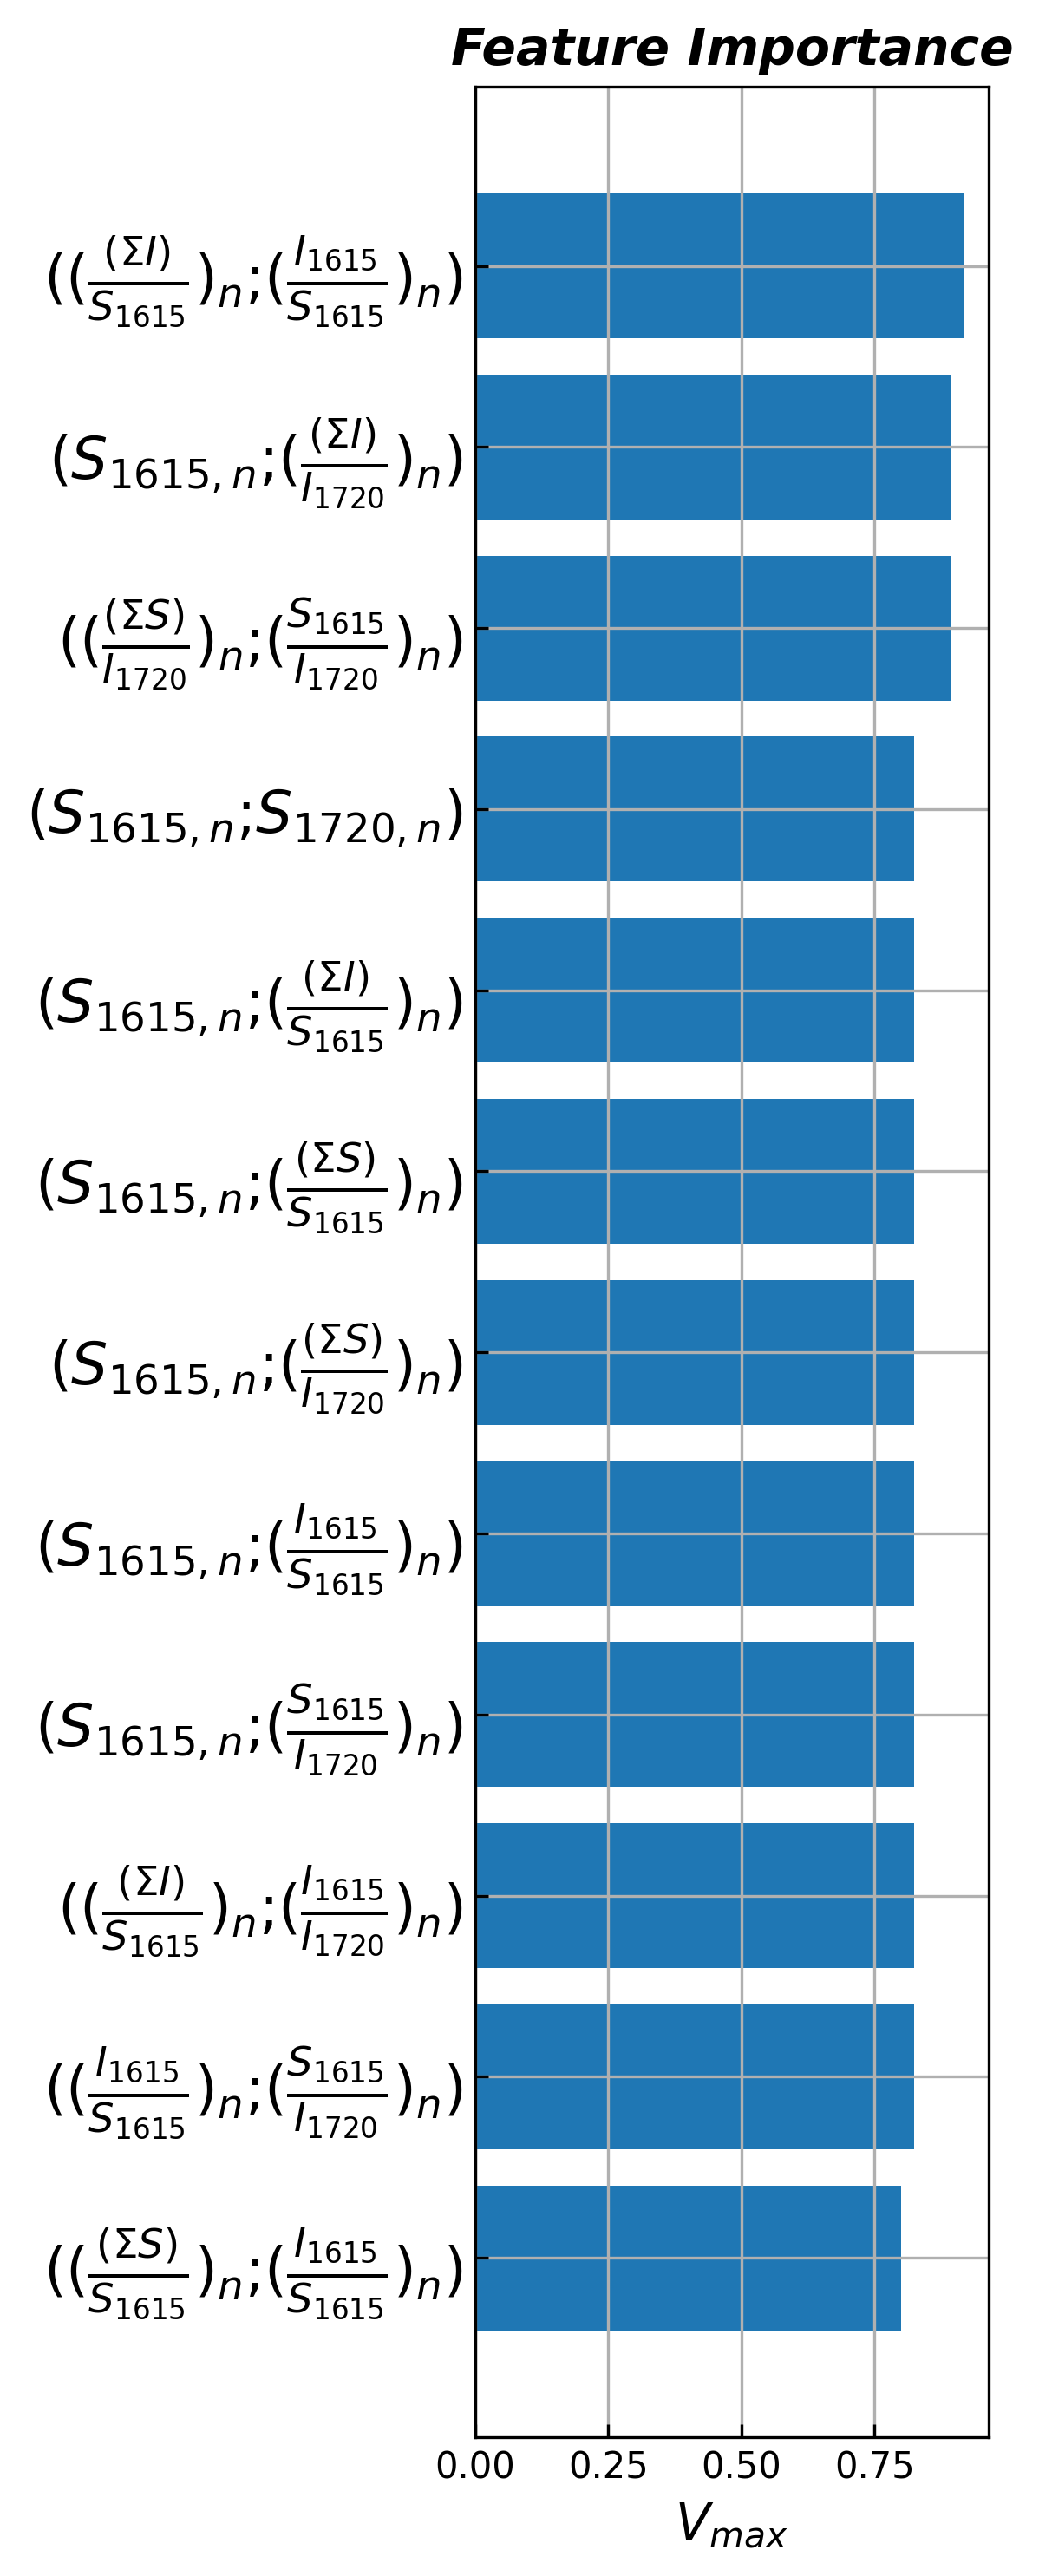

In [154]:
# Feature Importance для топ-16 фичей

fig = plt.figure(figsize=(4, 10), dpi=300, linewidth=1.0)

plt.grid(True)
plt.tick_params(direction='in')
ax = fig.gca()

ax.set_title('Feature Importance',
             fontname='DejaVu Sans',
             fontsize=14,
             fontstyle='italic',
             fontweight='bold')

barh_features_pairs = features_pairs_labels[:12]
barh_v_values = features_pairs_v_values[:12]

barh_plot = ax.barh(barh_features_pairs[::-1], barh_v_values[::-1])

ax.set_xlabel('$V_{max}$',
              fontname='DejaVu Sans',
              fontsize=14)
# ax.set_ylabel('$Feature pairs$',
#               fontname='DejaVu Sans',
#               fontsize=14,
#               rotation=90,
#               labelpad=10)

ax.set_yticklabels(barh_features_pairs[::-1], rotation=0, fontsize=16)

plt.tight_layout()
plt.savefig(path_to_save + '/feature_importance_barh.png', dpi=600)
plt.show()

## Кластеризация по отобранным фичам

In [143]:
top_n = 5

features_pairs_top5 = features_pairs[:top_n]
features_v_values_top5 = features_pairs_v_values[:top_n]

labels = [f'pair_top{i}' for i in range(1, top_n+1)]

In [142]:
features_pairs_opt_n_clusters = {}

for features_pair in features_pairs_top5:
    features_pair = list(features_pair)
    opt_n = optimal_number_of_clusters(data=ftir_features_df[features_pair],
                                       metric='v-measure',
                                       targets=targets)
    features_pairs_opt_n_clusters[tuple(features_pair)] = opt_n

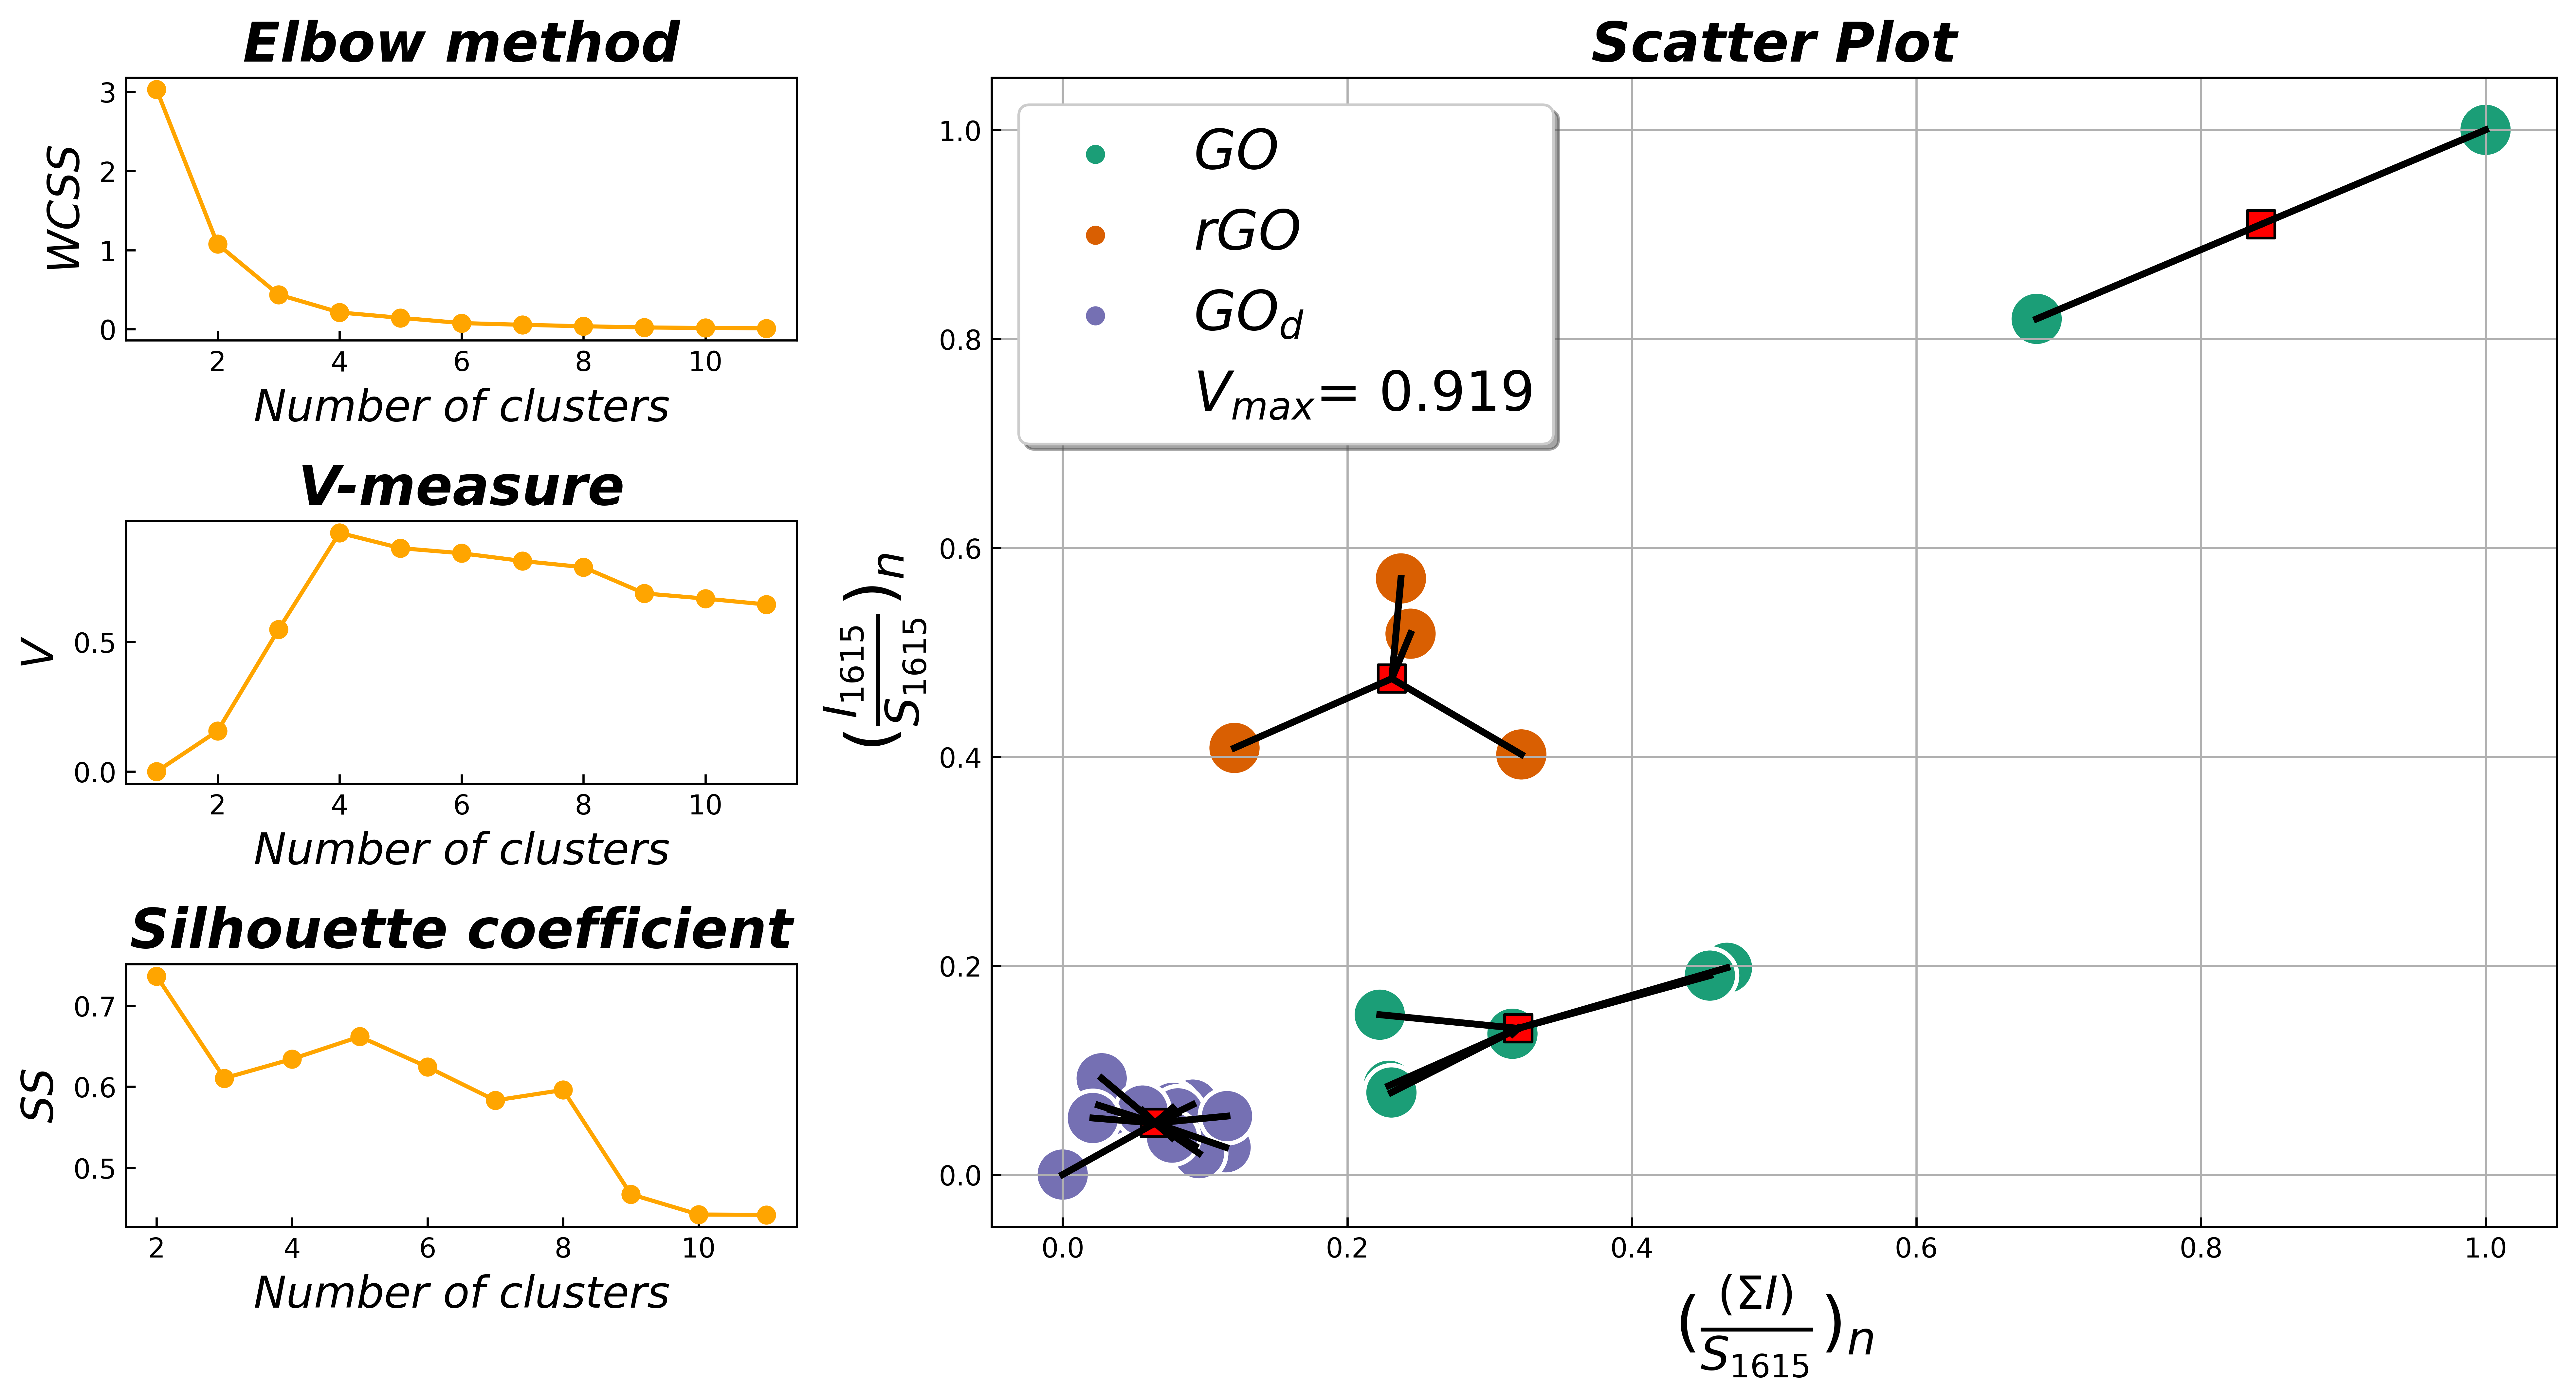

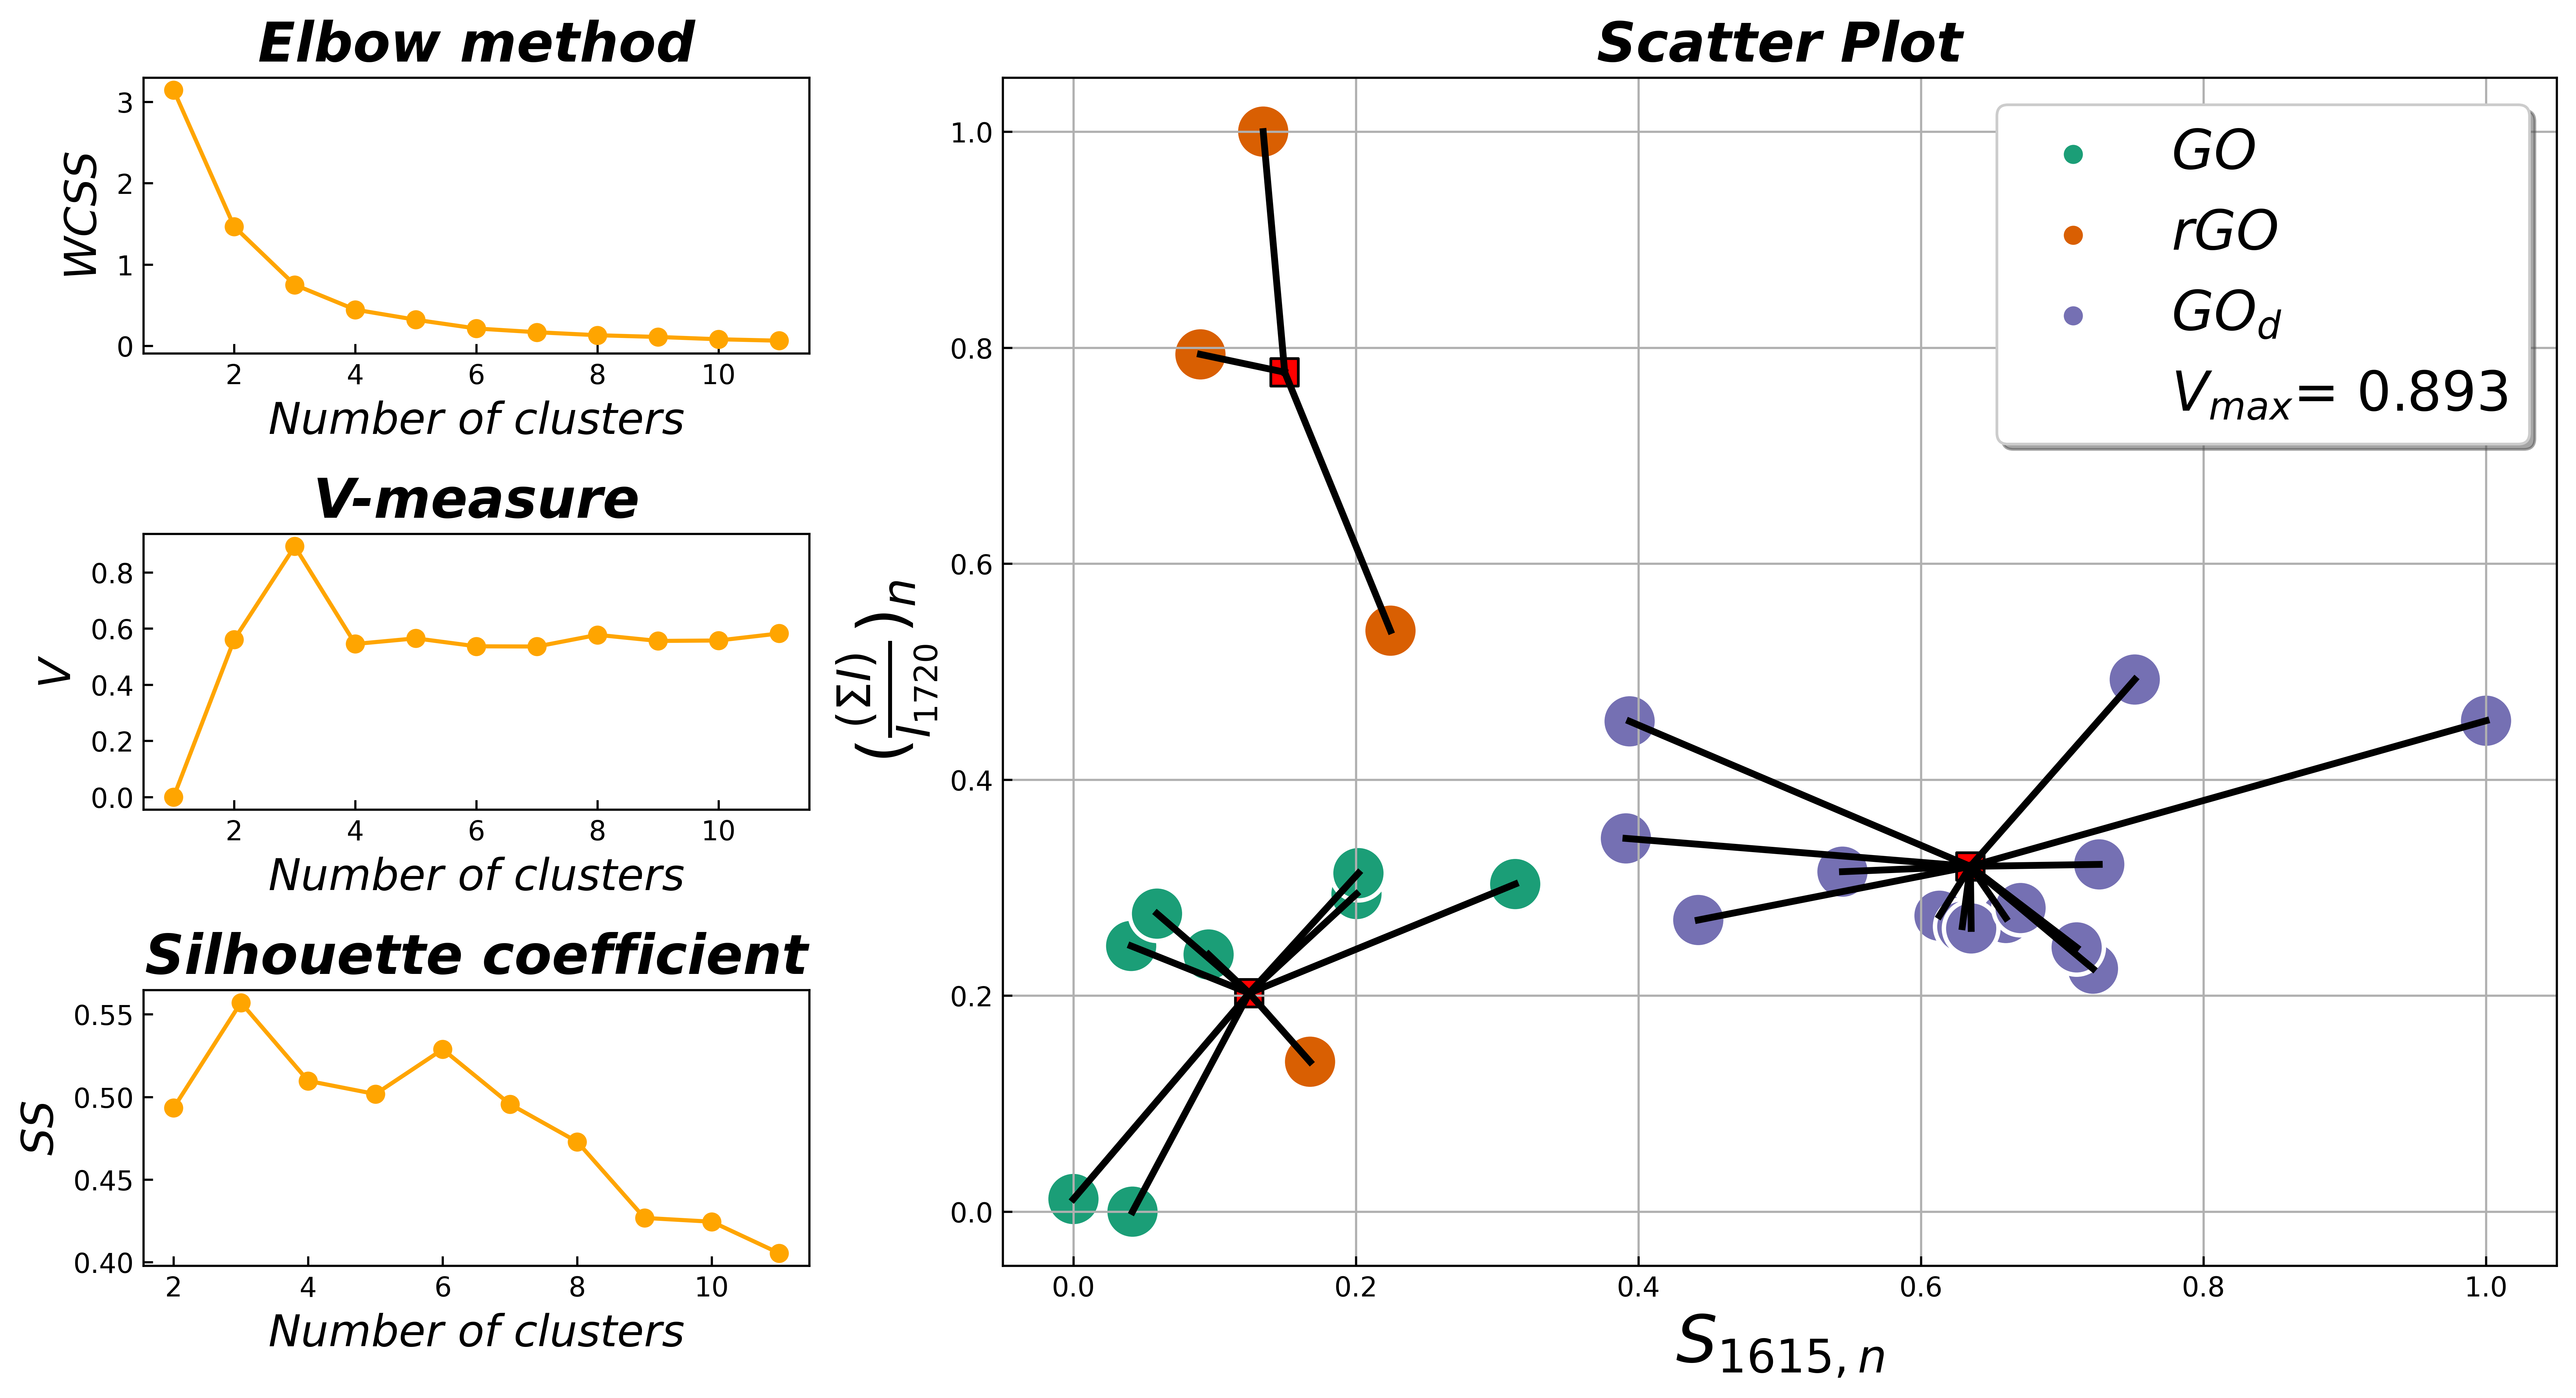

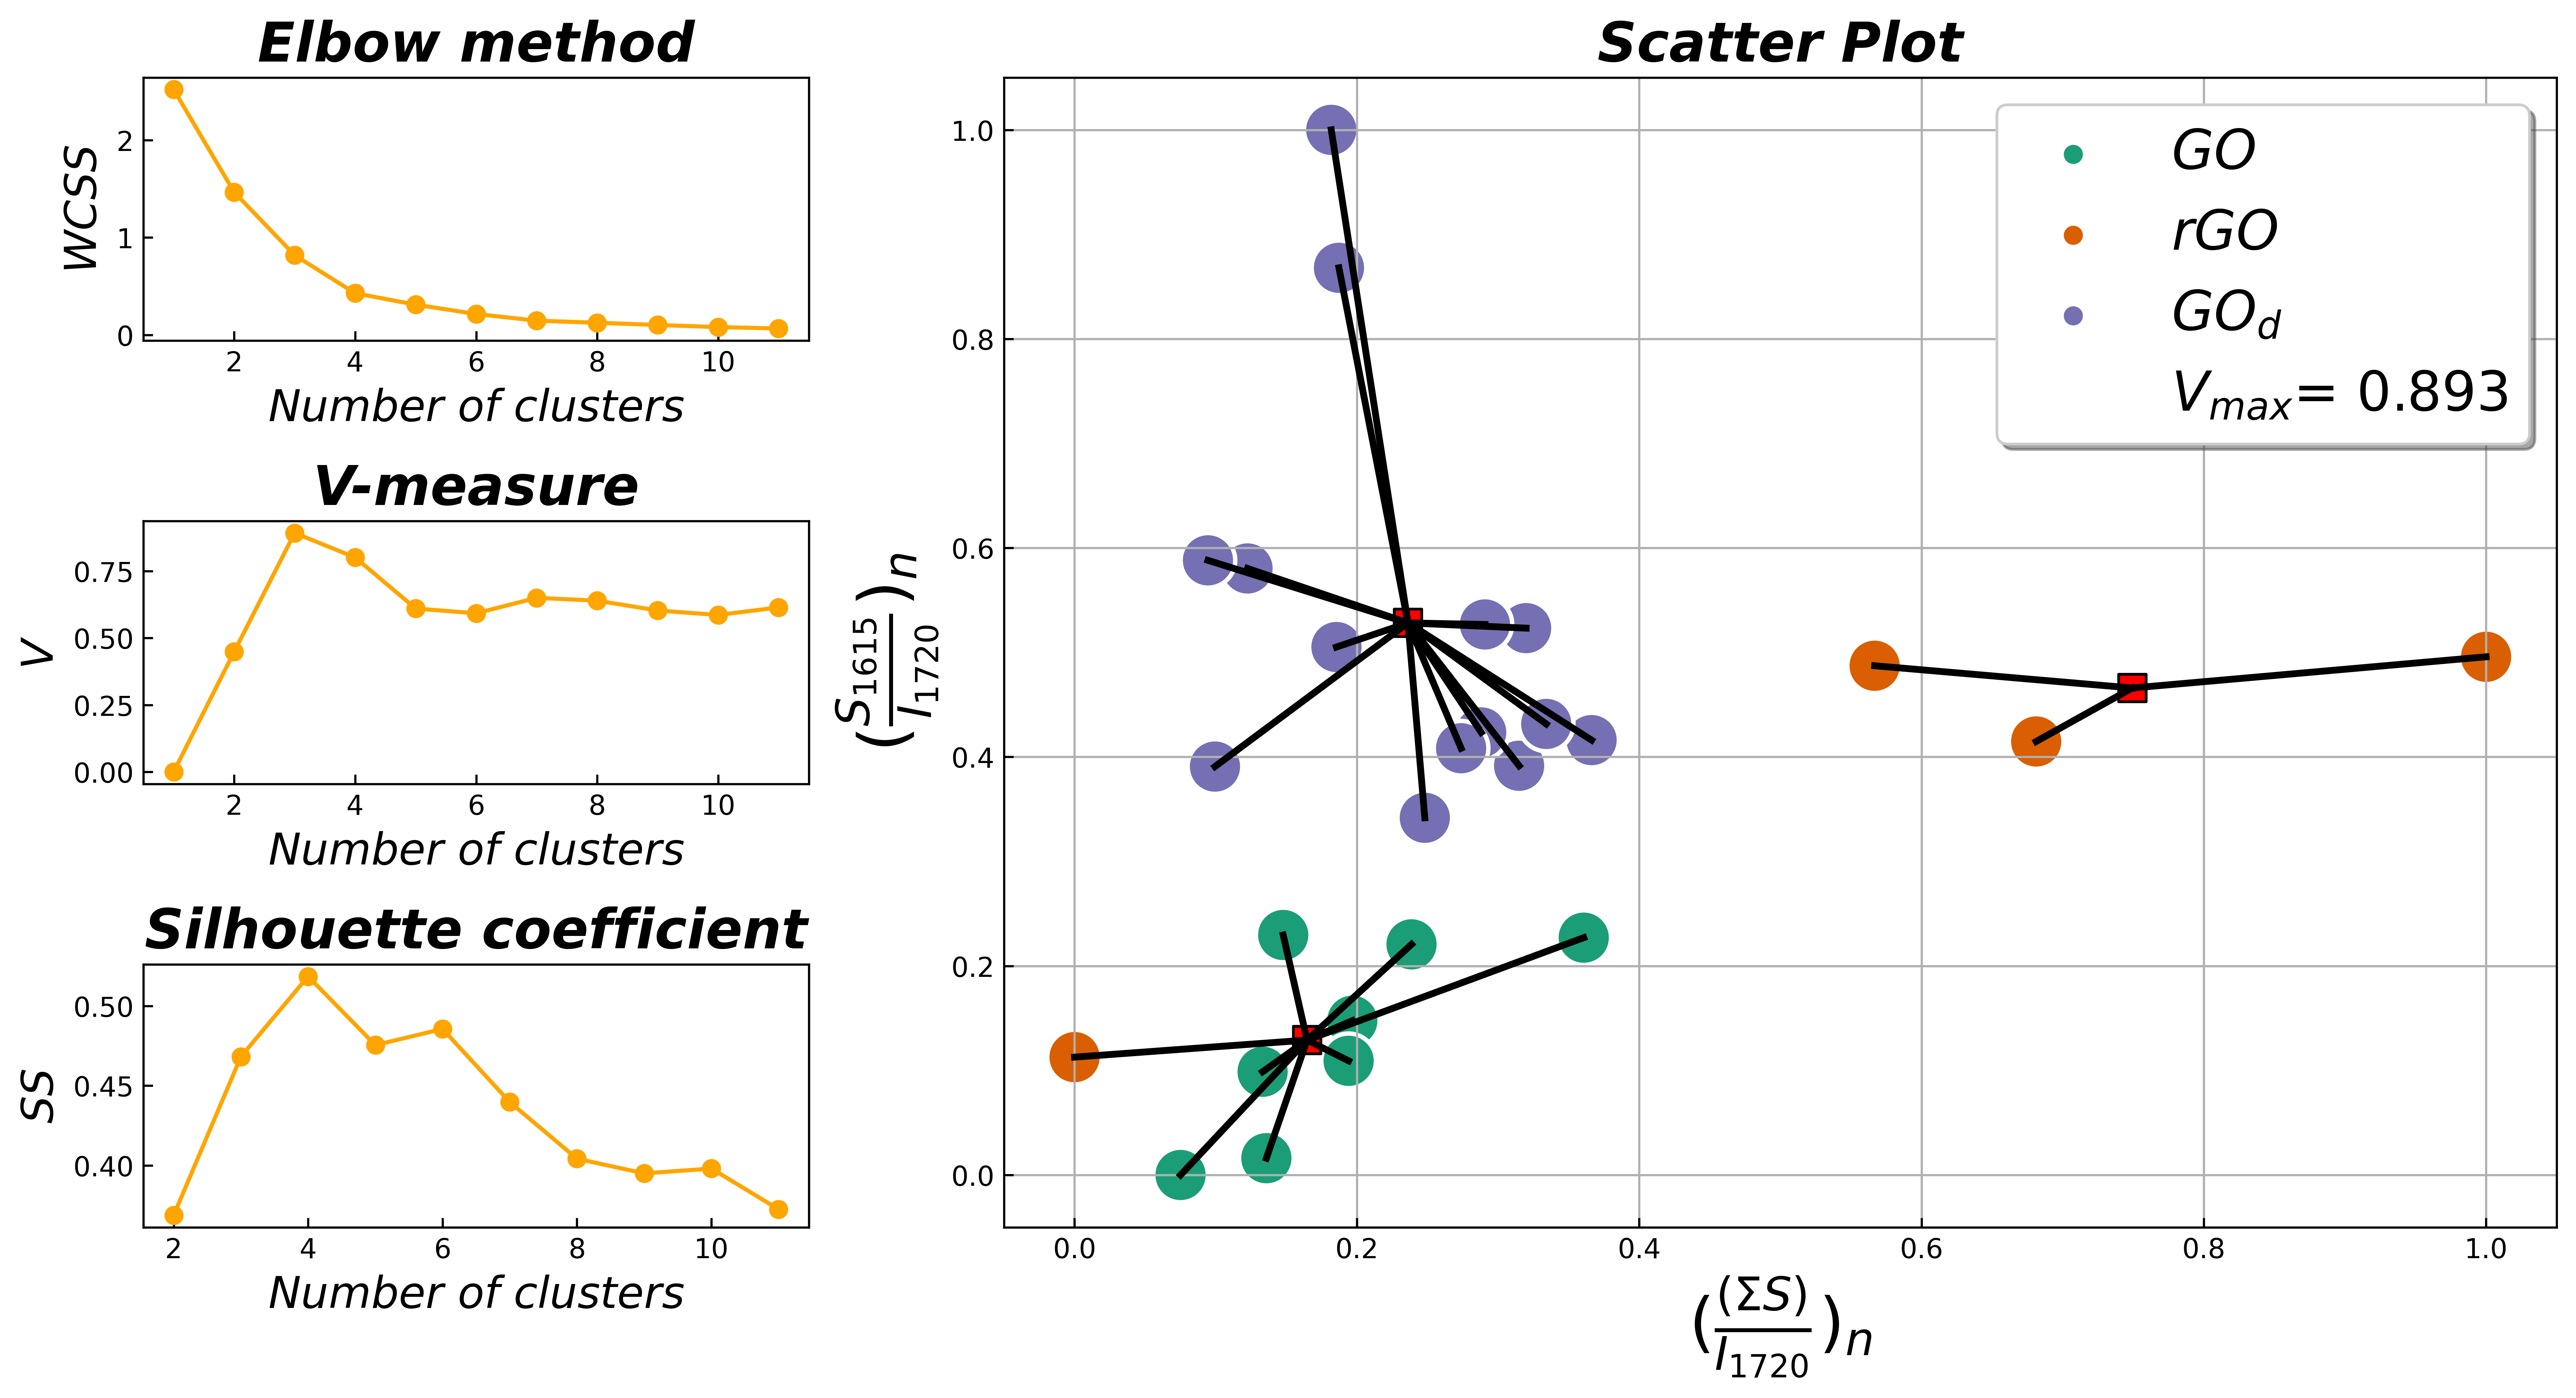

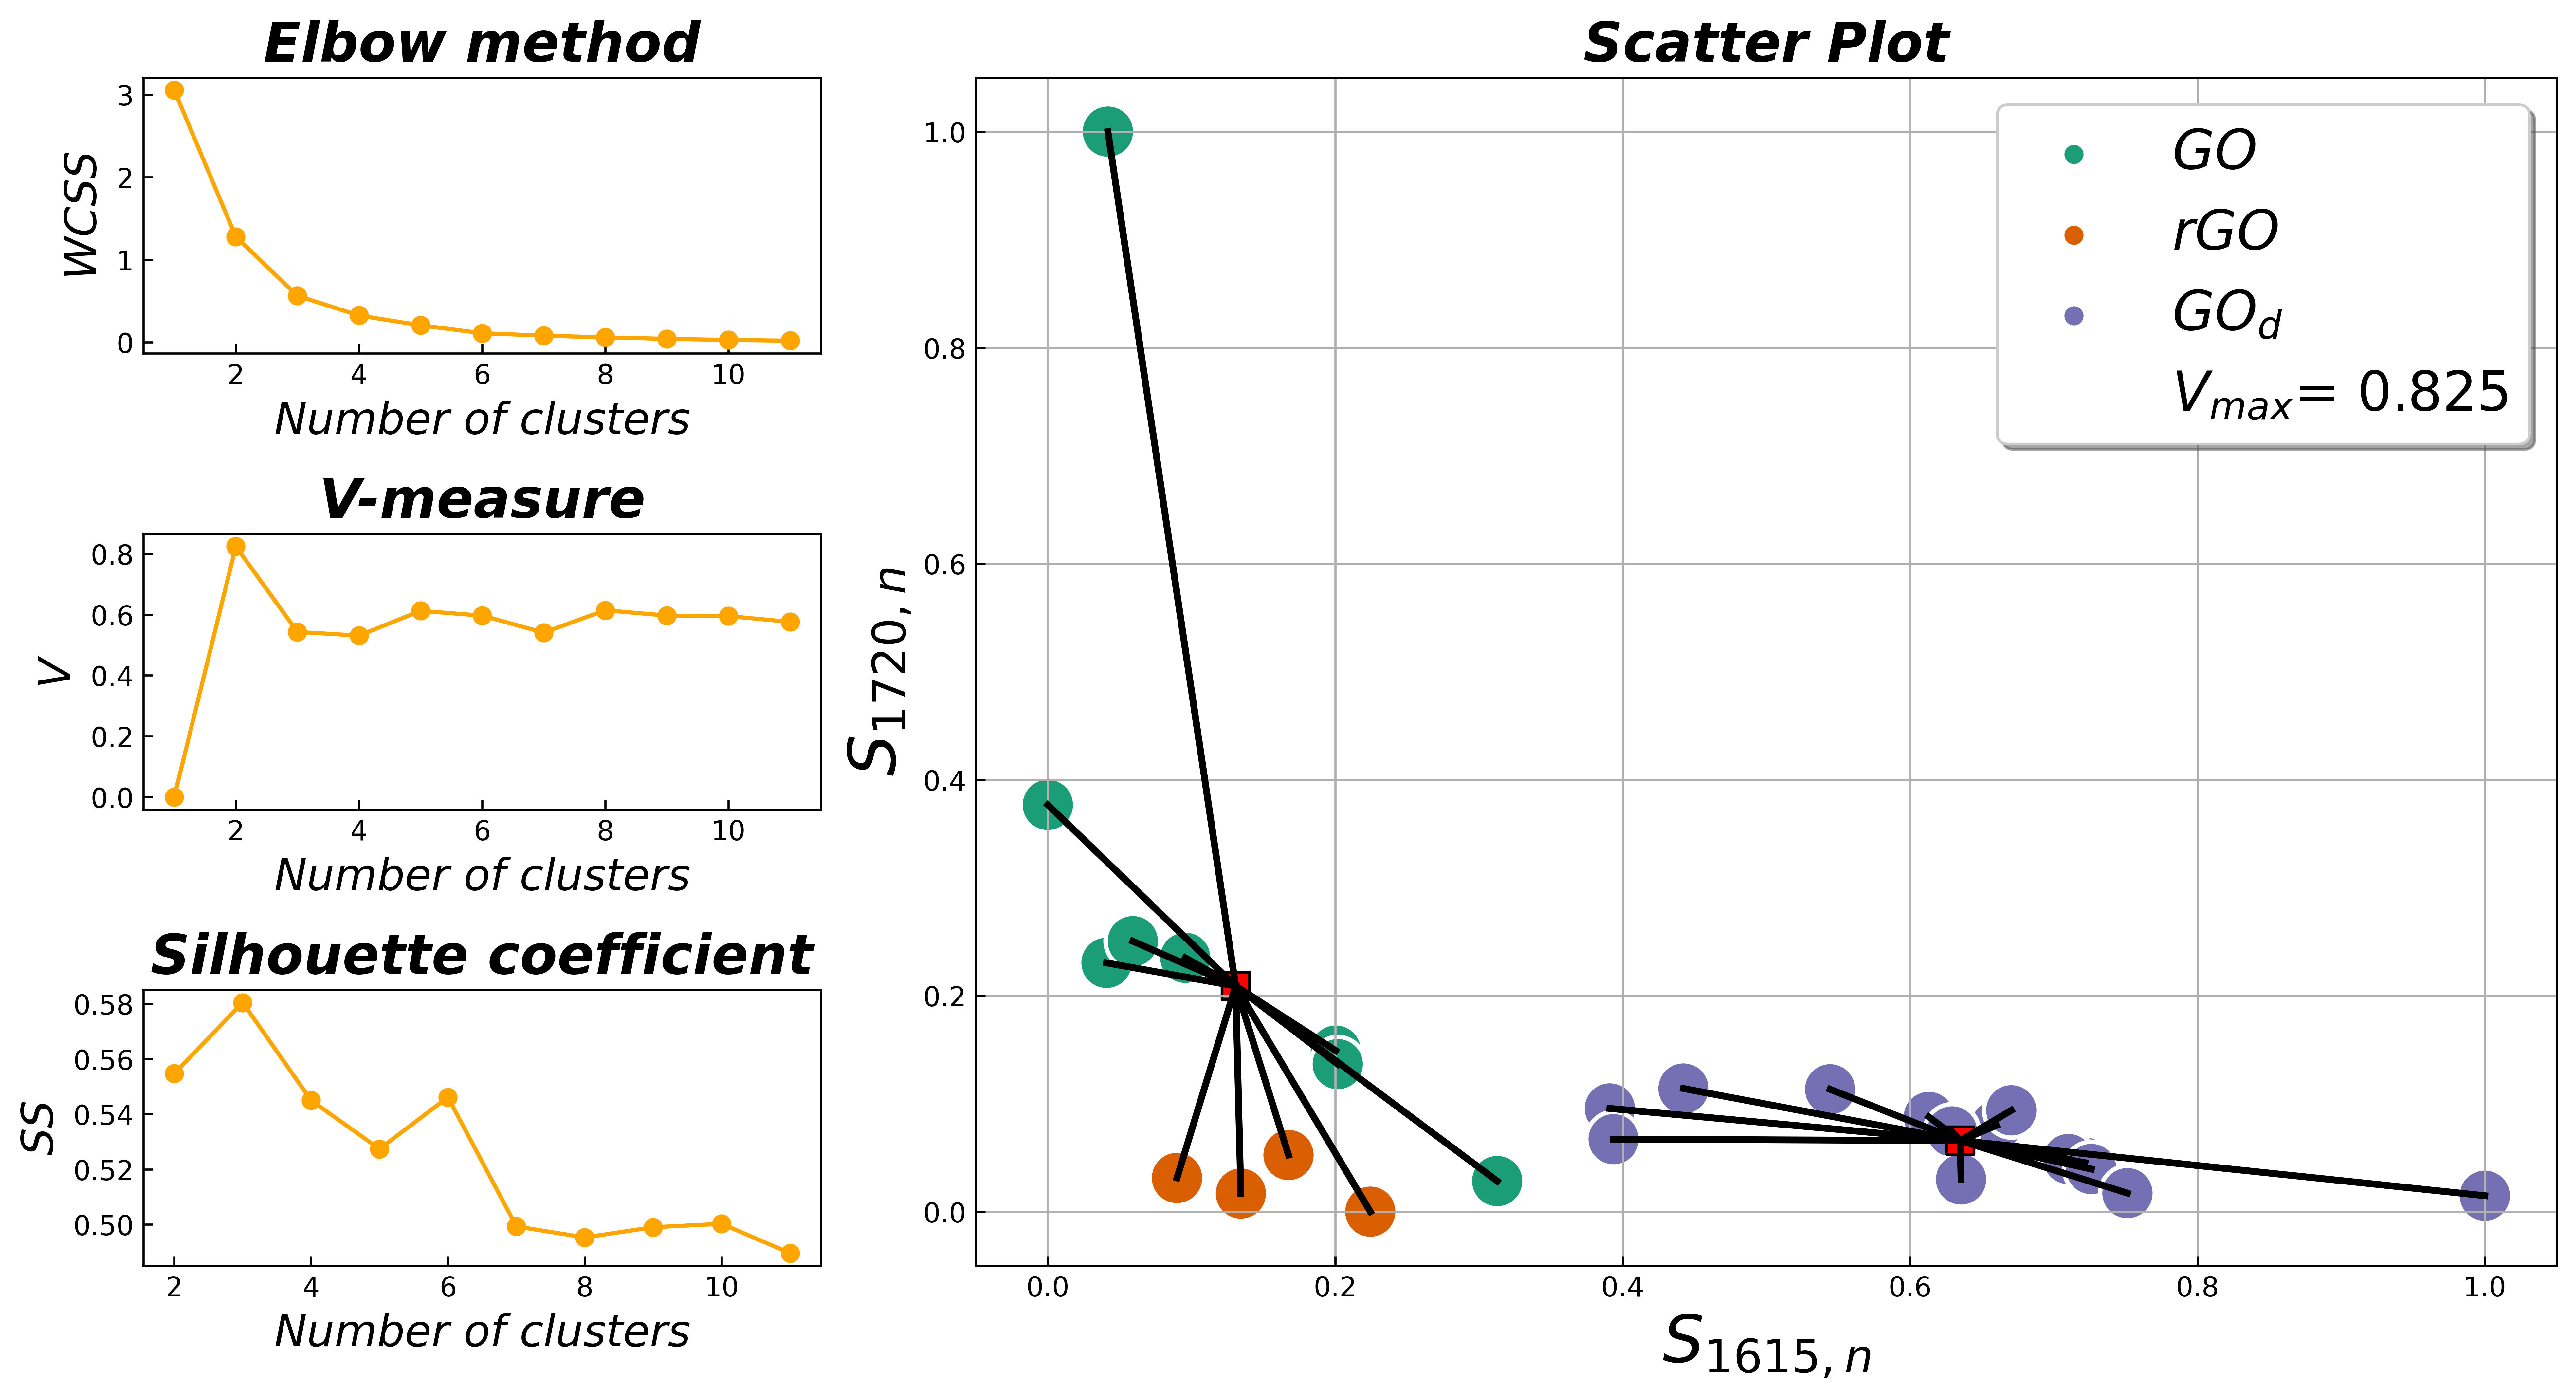

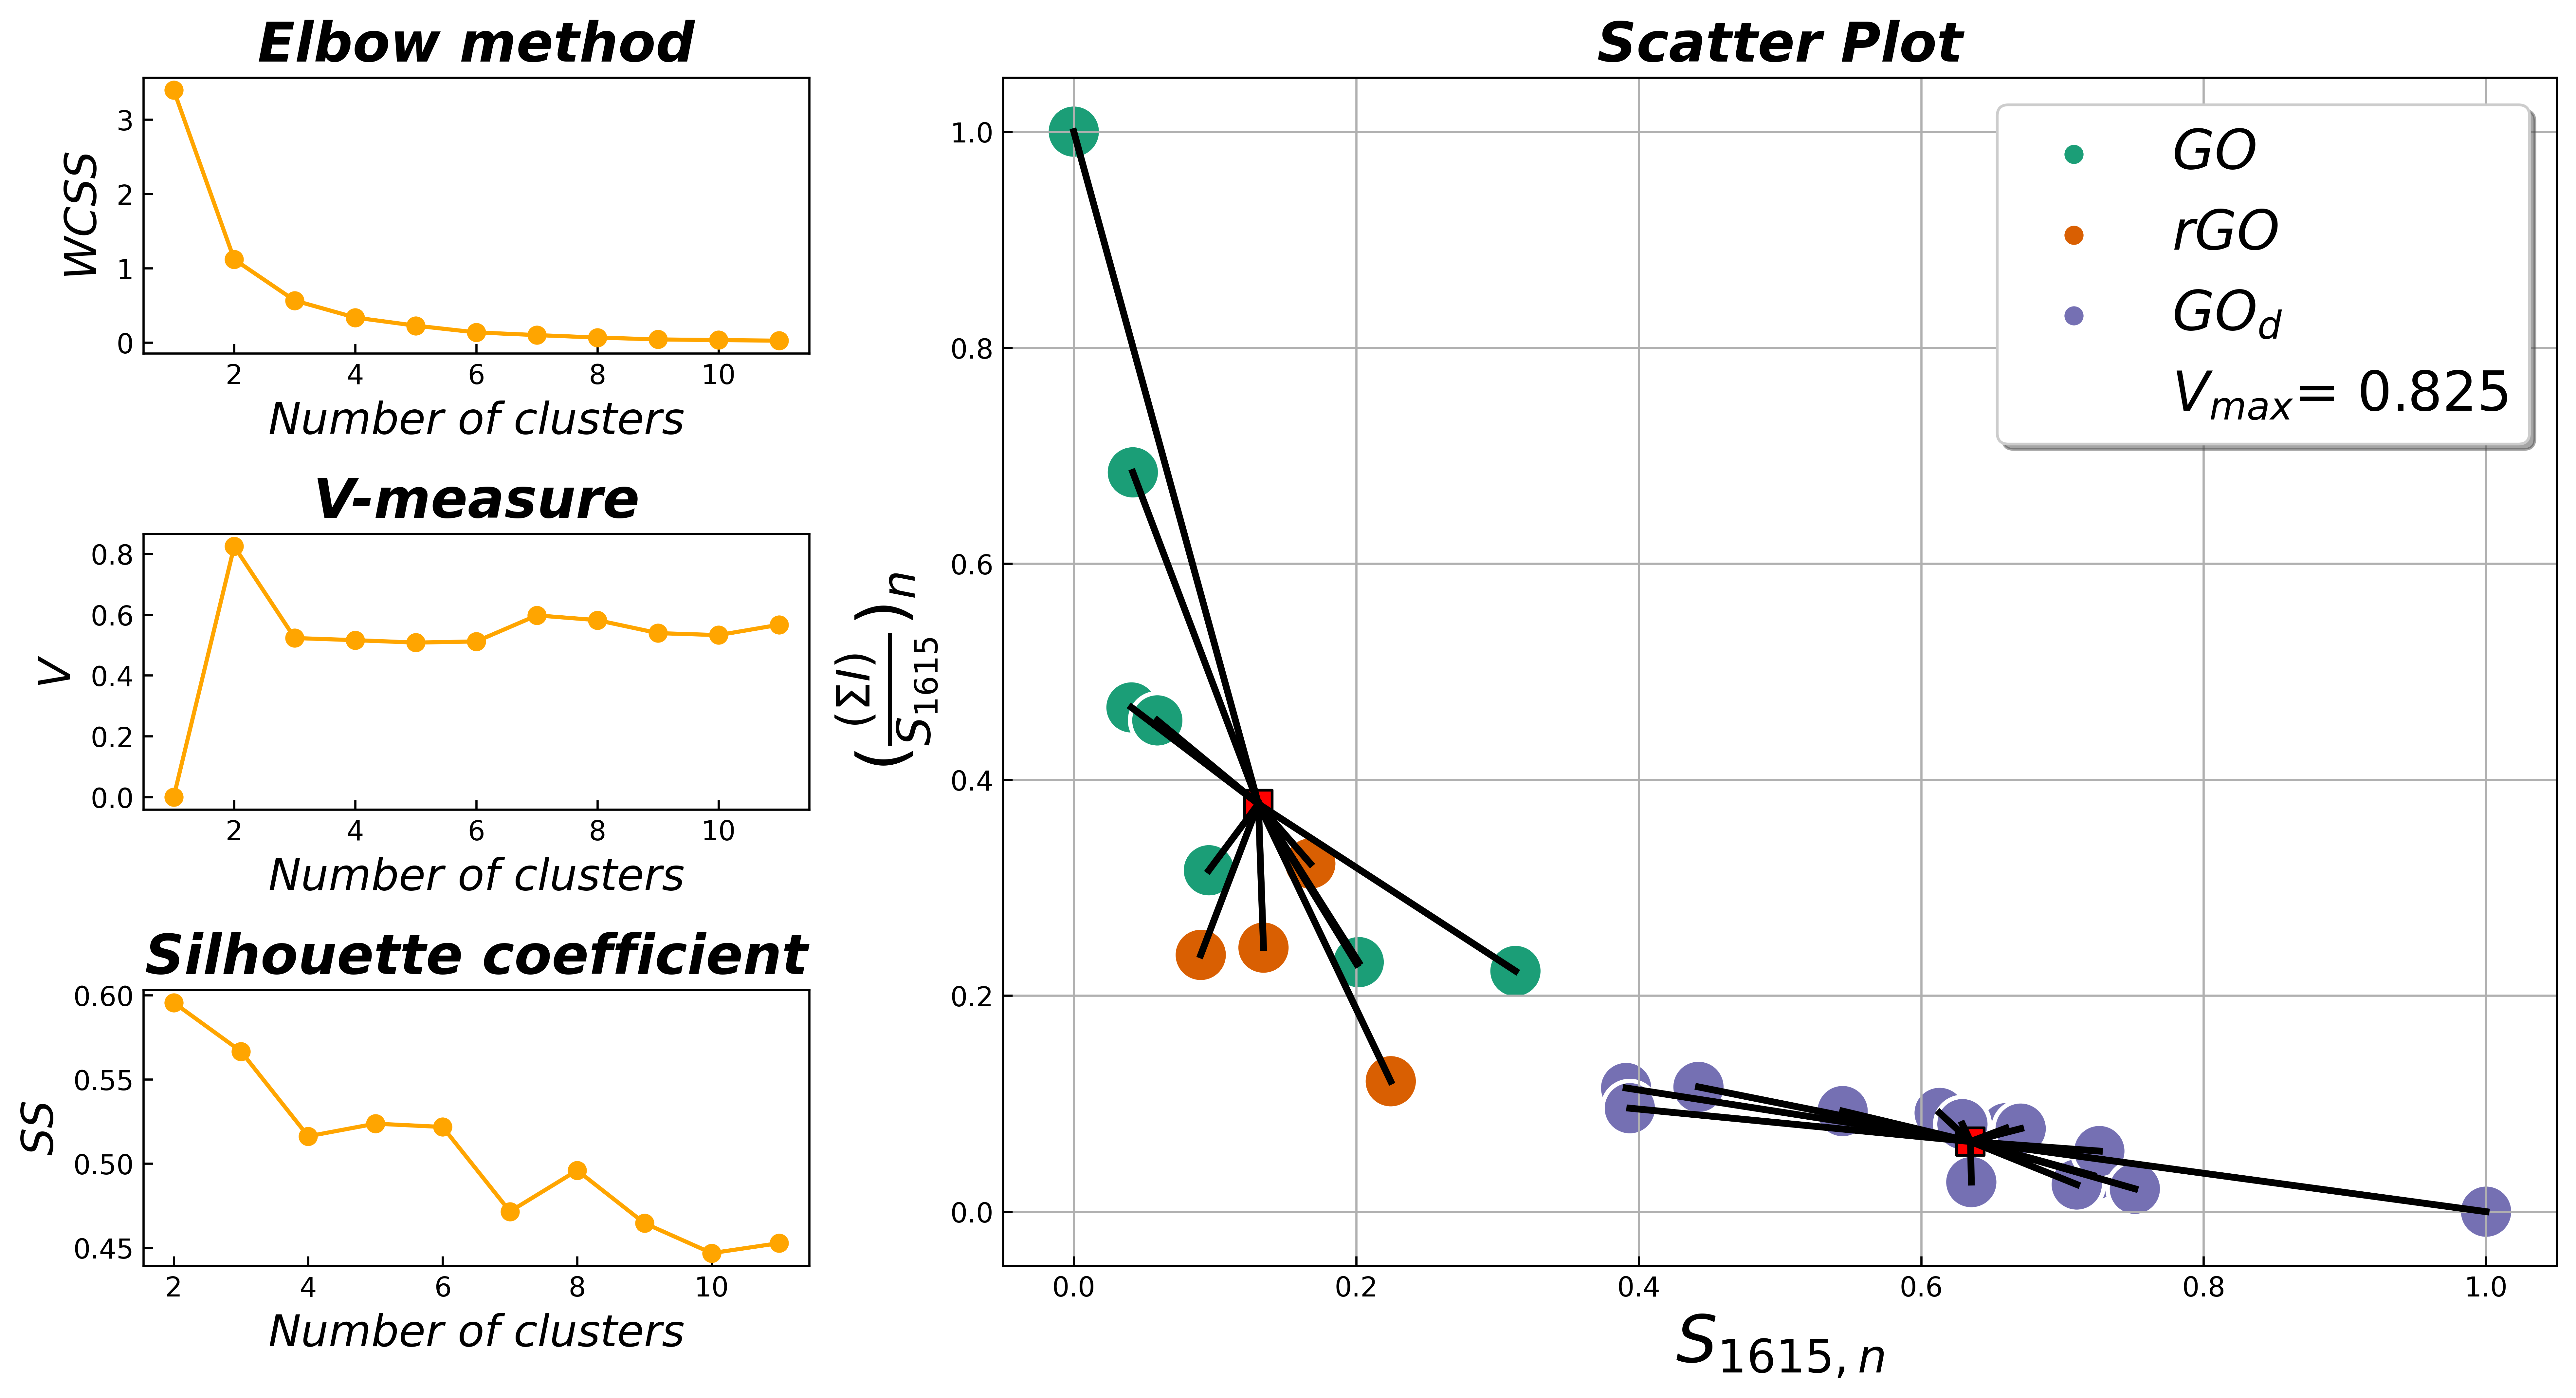

In [153]:
index = 0

for features_pair, opt_n_clusters in features_pairs_opt_n_clusters.items():
    features_pair = list(features_pair)
    cluster_analysis(data=ftir_features_df[list(features_pair)],
                 n_clusters=opt_n_clusters,
                 targets=targets,
                 hue_col=description,
#                  labels=data['id'],
                 figsize=(13, 7),
                 markersize=400,
                 save='y',
                 name_of_file=path_to_save + f'/{labels[index]}',
                 dpi=600)
    index += 1